## Project Stage - IV (Dashboard)

In [1]:
#!pip install matplotlib
#!pip install scikit-learn
!pip install dash --upgrade
!pip install statsmodels
!pip install dash --upgrade
!pip3 install dash --upgrade
!pip install jupyter-dash

     |████████████████████████████████| 9.9 MB 2.1 MB/s eta 0:00:01
  Attempting uninstall: dash
    Found existing installation: dash 2.7.0
    Uninstalling dash-2.7.0:
      Successfully uninstalled dash-2.7.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_rows', None)

In [3]:
from dash import Dash, dcc, html 
from jupyter_dash import JupyterDash
from dash import Dash, dash_table
from dash.dependencies import Input, Output


In [4]:
df = pd.read_csv("../../../data/super_df.csv")

## Create Scatter Plot, Map and Table
* The cell below creates a function for each of the graphs and table to be displayed on the app
* Styling is also added for the Div containers to be displayed with box shadows with margin to avoid overlapping with other containers
* Choropleth map is displayed by the States column and colored by a specific column (default=Norm_Deaths)

In [5]:
def create_graph(df):
    """ This function creates a scatter plot and returns the graph in a html.Div tag """
    
    fig = px.scatter(data_frame=df, 
                     x='Population', 
                     y='Norm_Deaths',
                     size='Unemployment raw value', 
                     trendline="ols", # linear regression line
                     trendline_scope='overall',
                     color='State')
    
    # add button for linear and log mode in scatter plot
    fig.update_layout(title_text="Mortality Rate against State Population",
                      updatemenus=[
                          dict(
                              buttons=[
                                  dict(label="Linear",
                                       method="relayout", 
                                       args=[{
                                           "yaxis.type": "linear",
                                            "xaxis.type": "linear"}]),
                                  dict(label="Log", 
                                       method="relayout", 
                                       args=[{"yaxis.type": "log",
                                             "xaxis.type": "log"}]),
                         ])
                      ]);
    
    return html.Div([
        html.H6('Scatter plot', style={'textAlign':'center',  'padding':'20px', 'margin': '0 auto'}, className='h6'),
        html.Div([
                dcc.Graph(id='scatter-plot', figure=fig)
        ], className='row')
    ], style={'box-shadow': '0 4px 8px 0 rgba(0, 0, 0, 0.2), 0 6px 20px 0 rgba(0, 0, 0, 0.19)', # add box shadow to graph container
              'margin':'40px auto'}, className='row')

def create_choropleth(df):
    """ This function creates a Choropleth map of the states of USA """
    
    fig = px.choropleth(
        data_frame=df,
        locations='State',
        color='Norm_Deaths',
        scope='usa',
        locationmode='USA-states',
        color_continuous_scale='Reds',
        title='Normalized Mortality Rate per State'
    )
    
    # update layout colorbar title
    fig.update_layout(coloraxis_colorbar=dict(
        title="Mortality Rate",
    ))

    return html.Div([
        html.H6('Choropleth Map by State', style={'textAlign': 'center', 'padding':'20px', 'margin': '0 auto'}, className='h6'),
        dcc.Graph(id='choropleth-map', figure=fig)
    ], className='row', style={'box-shadow': '0 4px 8px 0 rgba(0, 0, 0, 0.2), 0 6px 20px 0 rgba(0, 0, 0, 0.19)', # add box shadow to graph container
                               'margin':'40px auto'})
    
def create_table(df):
    """ This function creates a data table and allows the selection of columns to be displayed """
    
    return html.Div([
            html.H6('Data Table', style={'textAlign': 'center', 'padding':'20px', 'margin': '0 auto'}, className='h6'),
            
            # add a multi selection dropdown to select columns to be displayed
            html.Div([
                html.Label('Select columns to display:'),
                dcc.Dropdown(id='select-columns', options=[col for col in df.columns],
                      value=[col for col in df.columns[:10]], multi=True) 
            ], style={ 
                    'position': 'relative',
                    'width': '100%',
                    'margin': '0 auto',
                    'padding': '0 20px',
                    'box-sizing': 'border-box'
                }),
        
            # data table
            html.Div([
                dash_table.DataTable(
                    id='data-table',
                    data=df.to_dict('records'),
                    columns=[
                        {"name": i, "id": i} for i in df.columns
                    ],
                    style_table={'overflowX': 'scroll'}, # styling table structure to be scrollable
                    style_data={
                        'color': 'black',
                        'backgroundColor': 'white',
                        'textAlign': 'center'
                    }, # style table data
                    style_header={
                        'backgroundColor': 'rgb(210, 210, 210)',
                        'color': 'black',
                        'fontWeight': 'bold',
                        'textAlign': 'center'
                    }, # style table header (columns)
                    style_data_conditional=[
                        {
                            'if': {'row_index': 'odd'},
                            'backgroundColor': 'rgb(220, 220, 220)'
                        }
                    ], # style data to alternate rows color if the row index is odd
                    page_size=10 # limits the number of rows displayed to 10 and adds pagination to view more pages
                )
                
                ], style={ # add margin and padding to the table Div container
                    'position': 'relative',
                    'width': '100%',
                    'margin': '0 auto',
                    'padding': '0 20px',
                    'box-sizing': 'border-box'
                })
            ], className='row', 
            style={'box-shadow': '0 4px 8px 0 rgba(0, 0, 0, 0.2), 0 6px 20px 0 rgba(0, 0, 0, 0.19)', # add shadow to the Table container
                                       'margin':'40px auto'})


## Create app layout
* Add headers
* Add dropdown menu for all unique states in the states column
* Add dropdown menu for all variables(columns) from the dataframe
* Add Scatter Plot graph
* Add Choropleth map
* Add Data Table

In [6]:
def create_layout(app):
    """ Creates a genearal layou containing the graphs and table """
    
    layout = html.Div([
        html.Div([
            html.H1("Stage IV Dashboard", style={'textAlign': 'center'}, className='h1'),
            html.H4("Some texts here", style={'textAlign': 'center'}, className='h4'),
        ],  style={'padding':'20px', 'margin': '0 auto'}),
        html.Div([
            html.Div([
                html.Div([
                    # drop down for all states
                    html.Label('States:'),
                    dcc.Dropdown(id='dropdown-states',
                                options=['All'] + [state for state in df.State.unique()], value = 'All')
                ], className='six columns'),
                html.Div([
                    # drop down for all variables
                    html.Label('Variables:'),
                    dcc.Dropdown(id='dropdown-variable',
                                options=[var for var in df.columns], value = 'Norm_Deaths'),
                ], className='six columns')
            ], className='row',  style={'padding':'20px', 'margin': '0 auto'}),
            html.Div([
                create_graph(df), # add scatter plot
                create_choropleth(df), # add choropleth map
                create_table(df) # add data table
            ],  style={'padding':'20px', 'margin': '0 auto'})
        ], style={})
    ], style={})
    
    return layout

In [7]:
# external css stylesheets for app styling
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(
    __name__, 
    external_stylesheets=external_stylesheets, 
    suppress_callback_exceptions=True, # added to prevent callback errors
    meta_tags=[{"name": "viewport", "content": "width=device-width, initial-scale=1"}]
)
# app.scripts.config.serve_locally = False 

## Update layout elements (scatter plot, table and map)
* update table when new columns are selected from drop down by adding the new columns to the table displayed
* update scatter plot to filter data points by state selected from drop down or to display all states on graph if **All** is selected from dropdown
* update map to display only selected State and also color the states by the selected variable from the variables drop down

In [8]:
# callback to update table and display new columns that are selected
@app.callback(
    Output(component_id='data-table', component_property='data'),
    Output(component_id='data-table', component_property='columns'),
    [Input(component_id='select-columns', component_property='value')]
)
def update_table(select_columns):
    new_df = df.copy()
    new_df = new_df[select_columns]
    columns=[
                {"name": i, "id": i} for i in new_df.columns
            ]
    return new_df.to_dict('records'), columns

# callback to update scatter plots to display only data partaining to specific states
@app.callback(
    Output(component_id='scatter-plot', component_property='figure'), # update the graph with new result
    [Input(component_id='dropdown-states', component_property='value')] # takes selected value from states dropdown as input
)
def update_graph(state):
    new_df = df.copy()
    def graph(new_df):
        fig = px.scatter(data_frame=new_df, 
                             x='Population', 
                             y='Norm_Deaths',
                             size='Unemployment raw value', 
                             trendline="ols", # linear regression line,
                             trendline_scope='overall',
                             color='State')
        fig.update_layout(title_text="Mortality Rate against State Population",
                          updatemenus=[
                              dict(
                                  buttons=[
                                      dict(label="Linear",
                                           method="relayout", 
                                           args=[{"yaxis.type": "linear",
                                                 "xaxis.type": "linear"}]),
                                      dict(label="Log", 
                                           method="relayout", 
                                           args=[{"yaxis.type": "log",
                                                 "xaxis.type": "log"}]),
                             ])
                          ]);
        return fig
    
    if state != 'All':
        # filter data by selected column and updates graph with filtered dataframe result
        new_df = new_df[new_df['State'] == state]
        fig = graph(new_df)
        return fig
    else:
        # updates scatter plot with original dataframe values if All is selected from dropdown
        return graph(new_df)

# update map to display only selected State and also color the states by the selected variable from drop down
@app.callback(
    Output(component_id='choropleth-map', component_property='figure'),
    Input(component_id='dropdown-variable', component_property='value'),
    Input(component_id='dropdown-states', component_property='value')
)
def update_map(variable, state):
    new_df = df.copy()
    def graph(new_df, variable):
        
        fig = px.choropleth(
            data_frame=new_df,
            locations='State',
            color=variable,
            scope='usa',
            locationmode='USA-states',
            color_continuous_scale='Reds',
            title=f'{variable} per State'
        )
        fig.update_layout(coloraxis_colorbar=dict(
            title=f"{variable}",
        ))
    
        return fig
    
    if state == 'All': # display all states
        fig = graph(new_df, variable)
        return fig
    else: # display only selected state
        new_df = new_df[new_df['State']==state]
        fig = graph(new_df, variable)
    
        return fig

In [9]:
app.layout = create_layout(app)

In [10]:
app.run_server(mode='external', debug = True, port=8055)

Dash app running on http://127.0.0.1:8055/


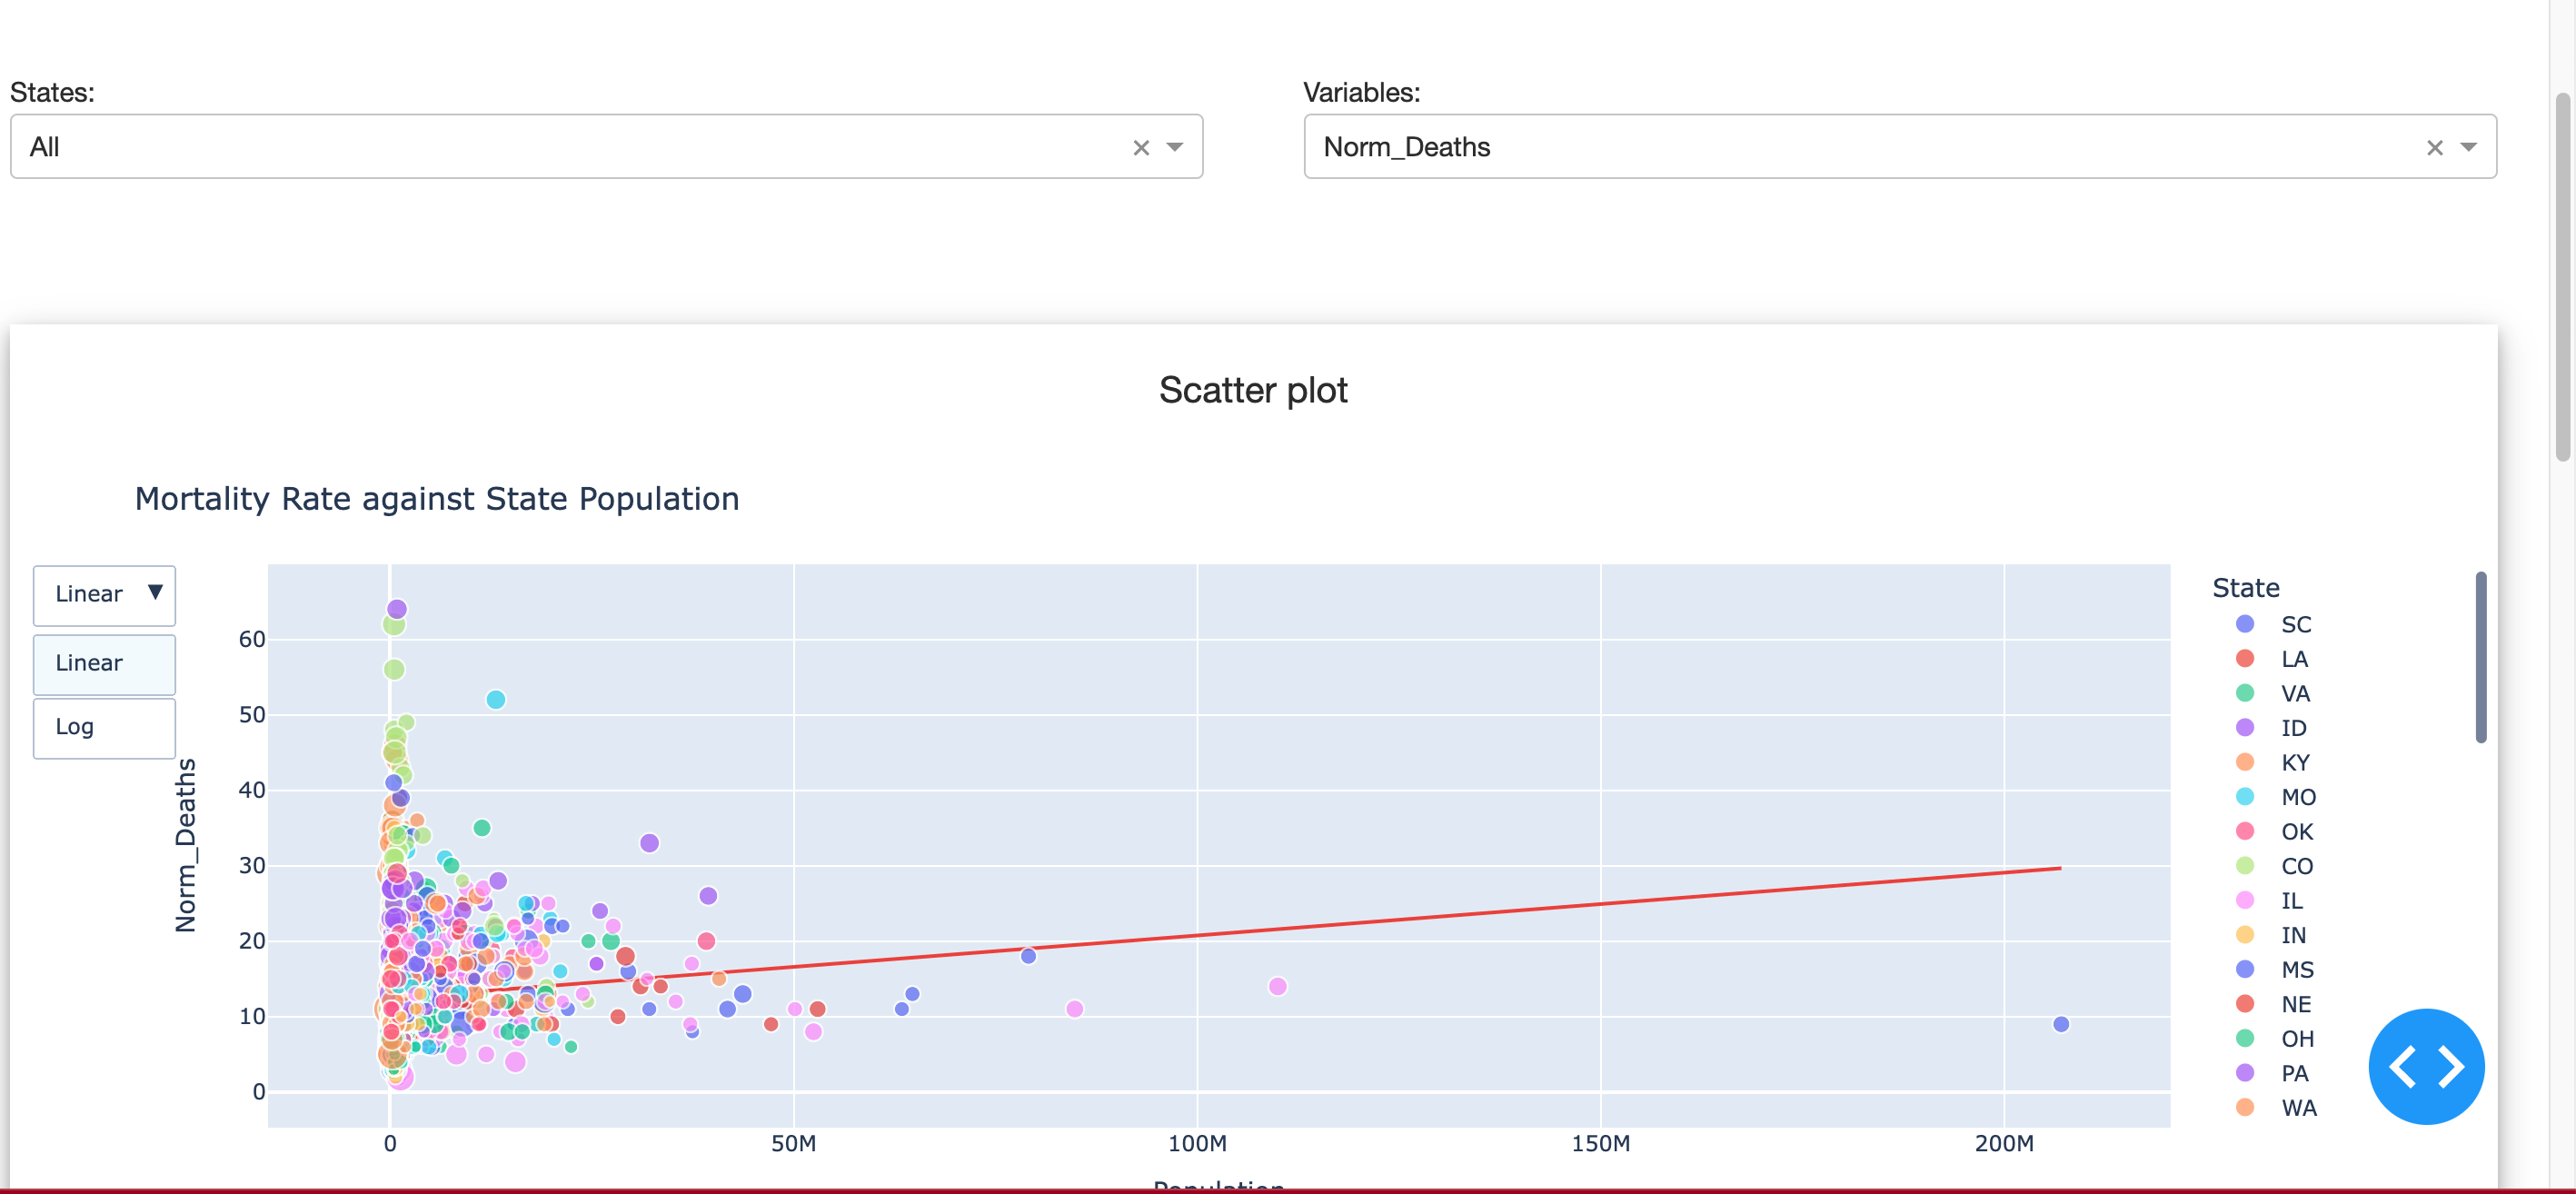

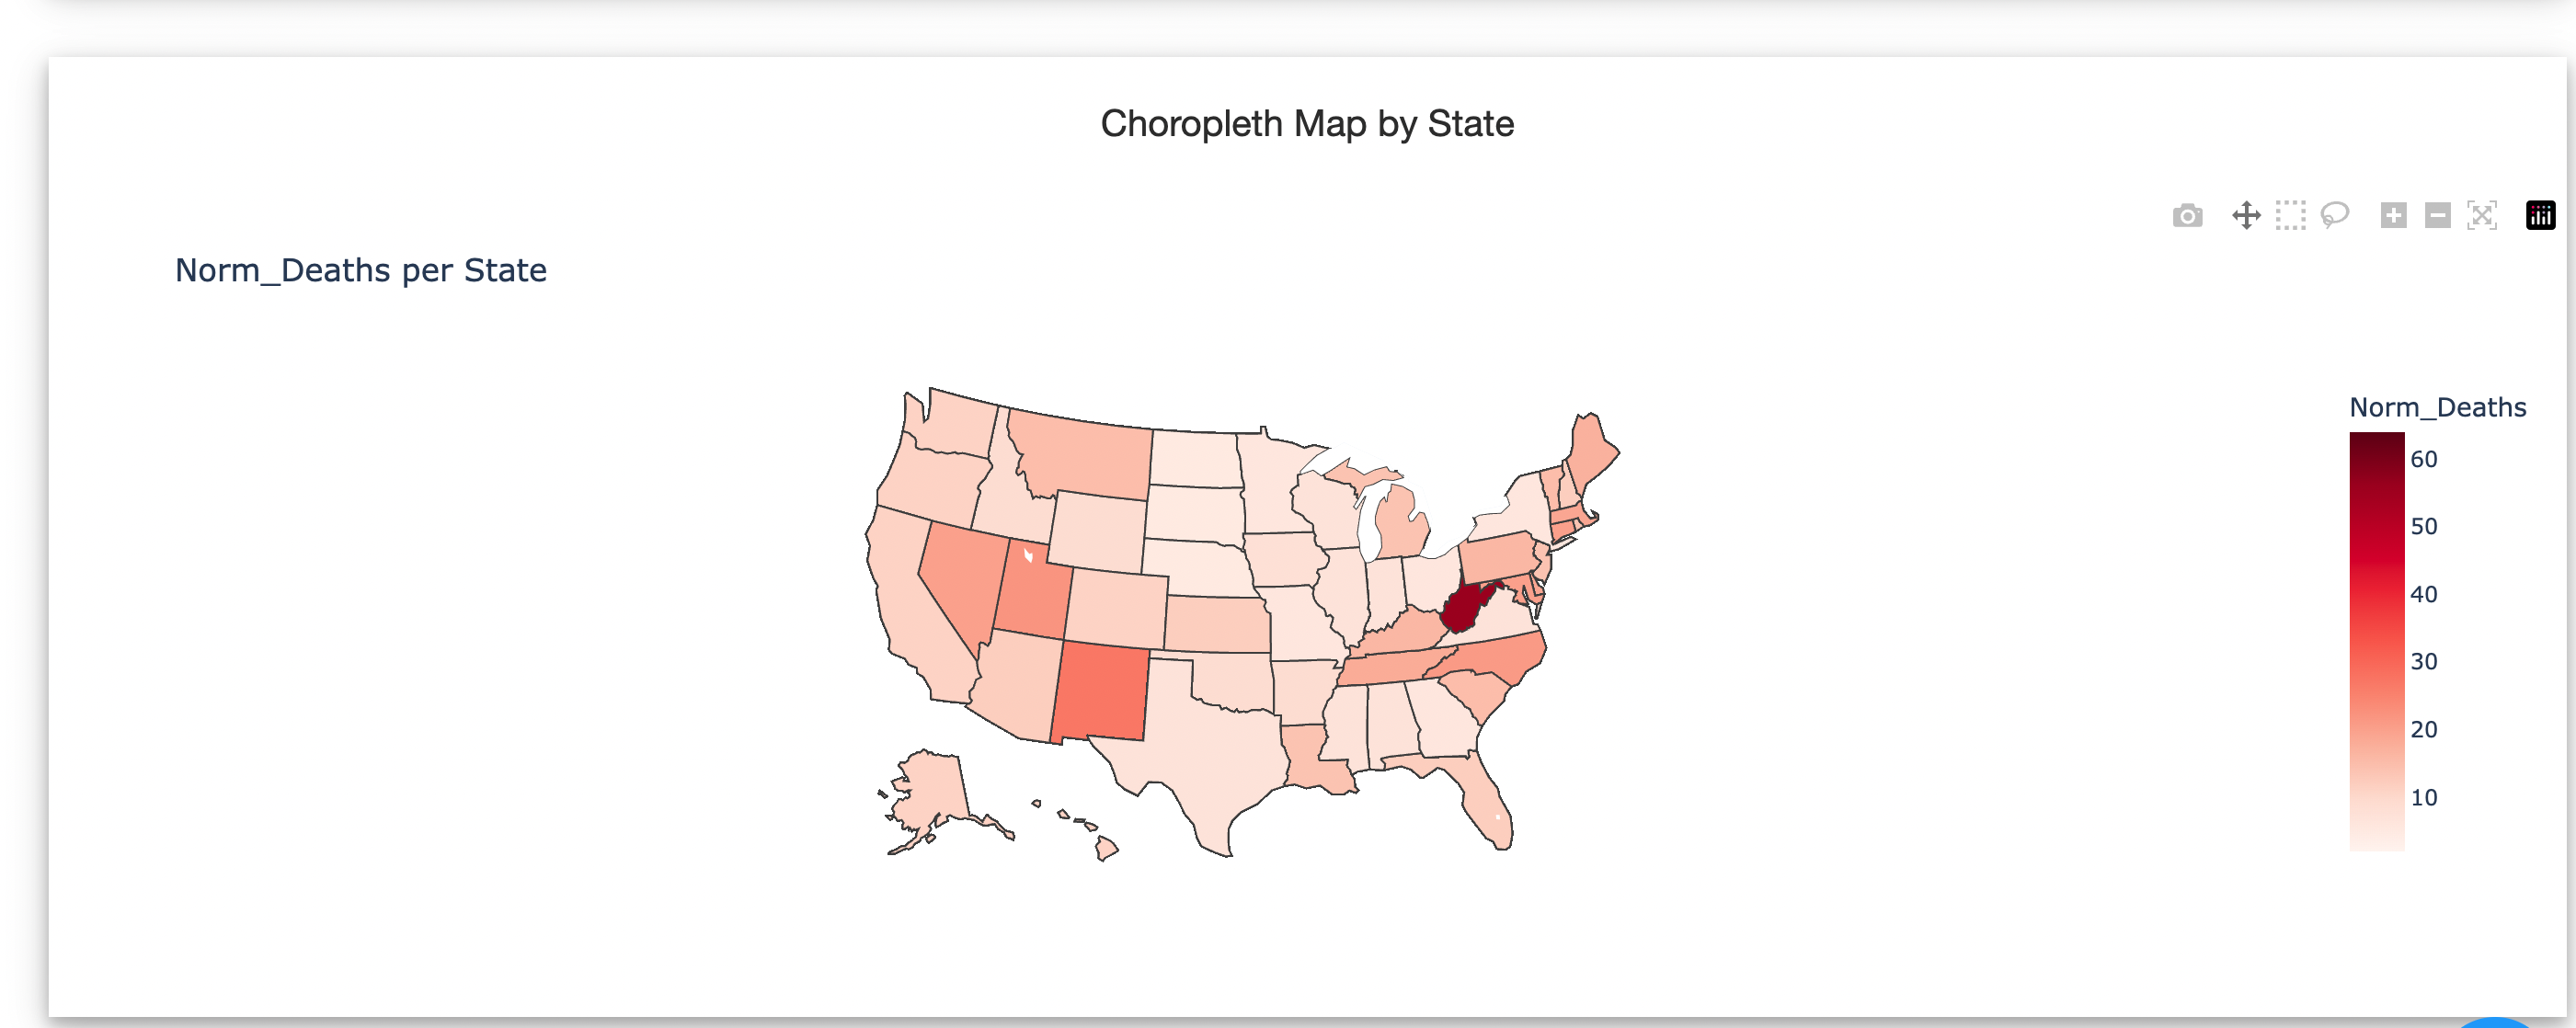

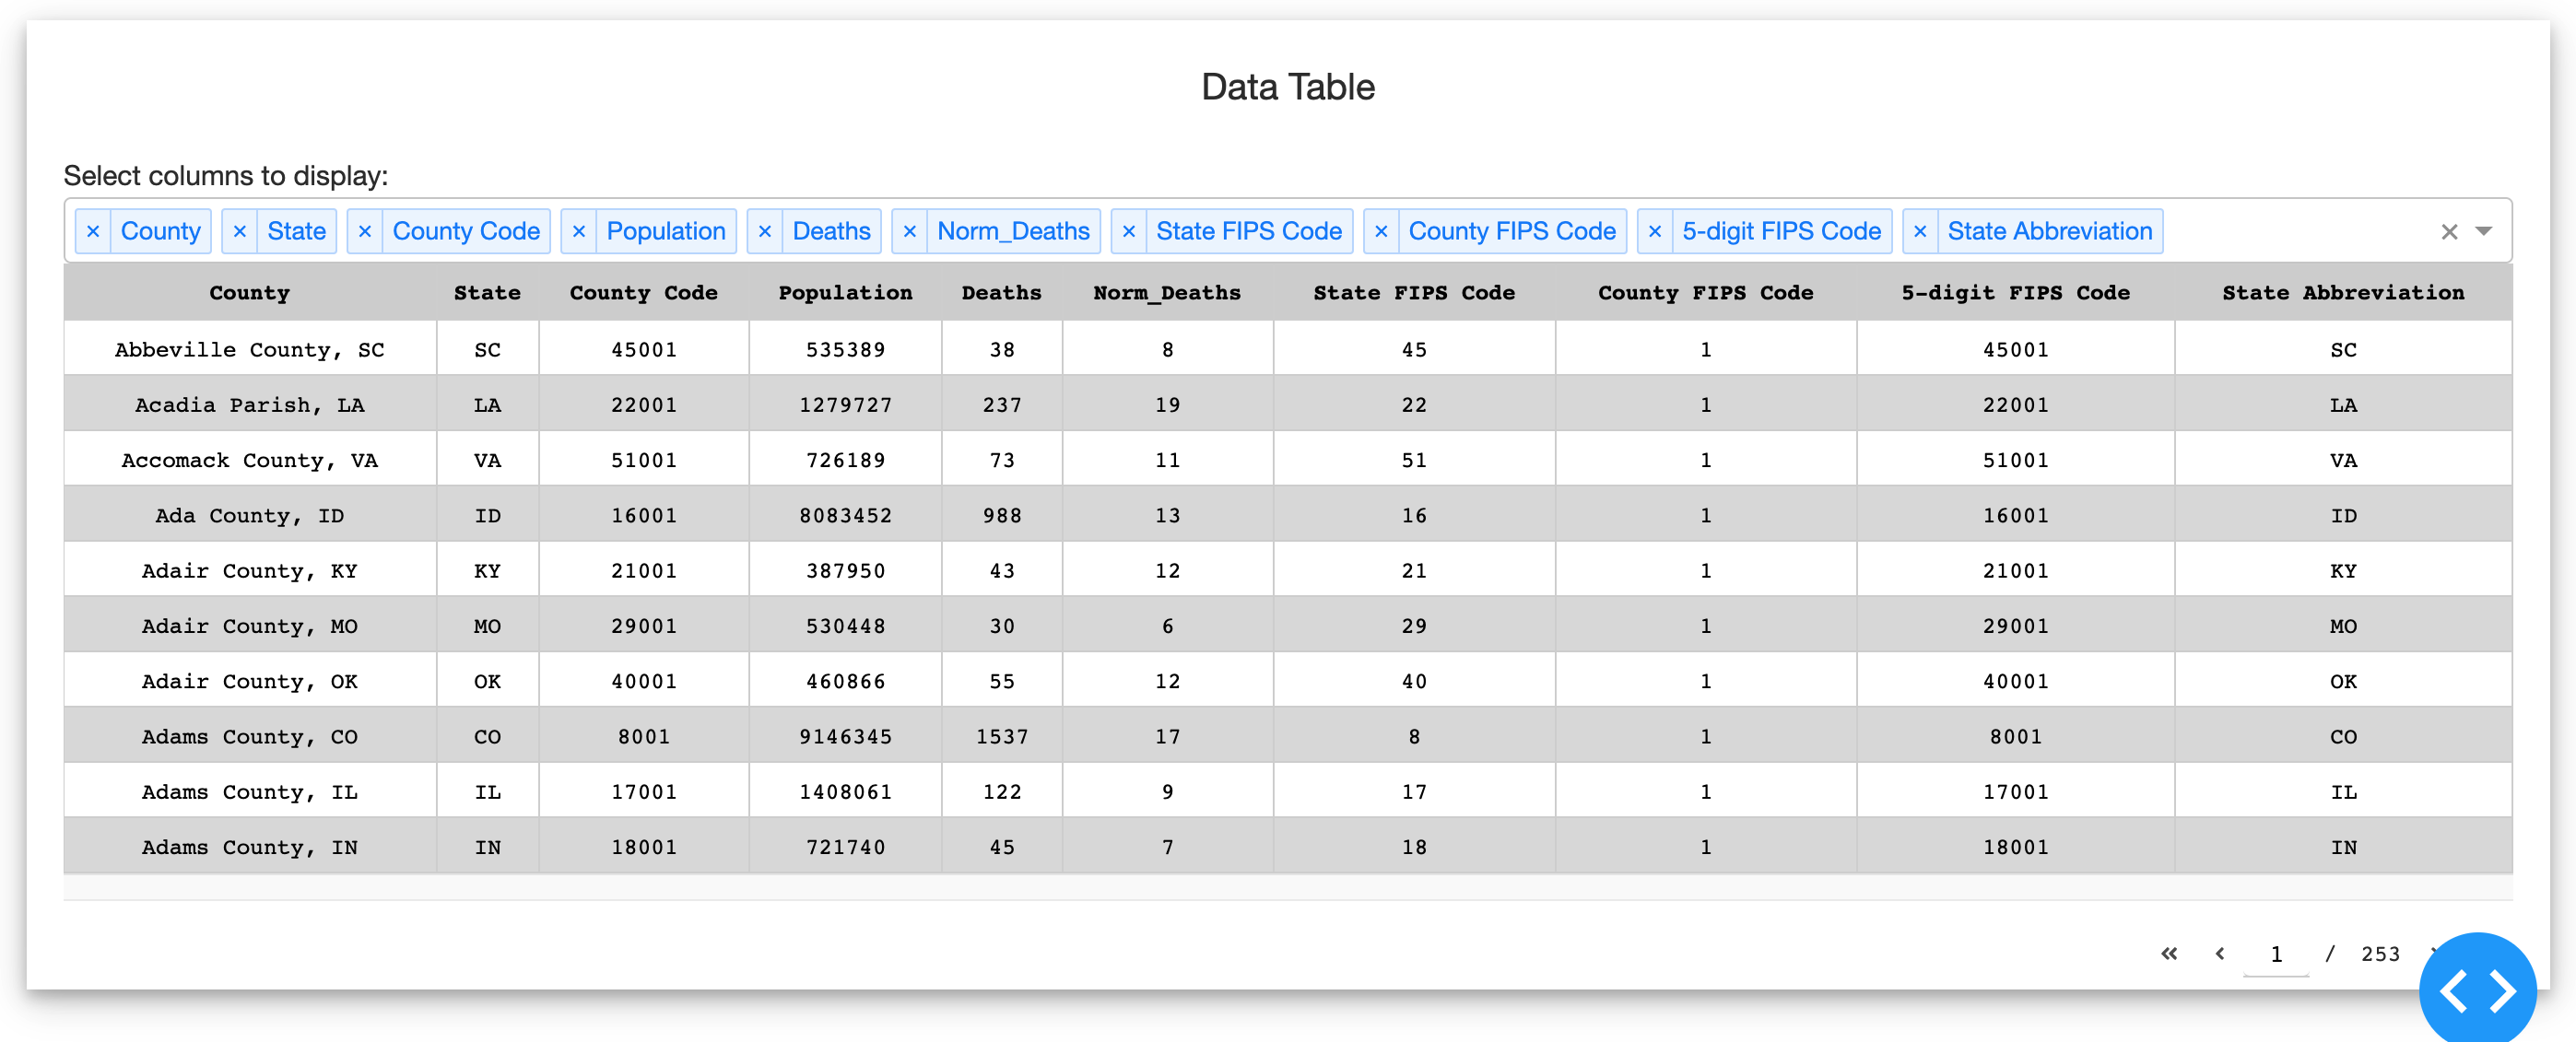